<a href="https://colab.research.google.com/github/mneae/insurance-forecast/blob/main/medical_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link: https://www.kaggle.com/datasets/mirichoi0218/insurance

We will build a health insurance cost prediction model based on personal information using this dataset from Kaggle.

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

Let's add the libraries for our study and load our data set.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')
#Uyarıların görünmemesi için

In [3]:
insurance = pd.read_csv("insurance.csv")
df = insurance.copy()
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


When we look at the data set, we see that there are no null values. The standard deviation values are not too high. The distribution of the variables looks normal.

Let's look at the category information and the number of categories contained in categorical variables.

In [6]:
print("Value counts of {}\n".format(df.value_counts("sex")))
print("Value counts of {}\n".format(df.value_counts("smoker")))
print("Value counts of {}\n".format(df.value_counts("region")))

Value counts of sex
male      676
female    662
dtype: int64

Value counts of smoker
no     1064
yes     274
dtype: int64

Value counts of region
southeast    364
northwest    325
southwest    325
northeast    324
dtype: int64



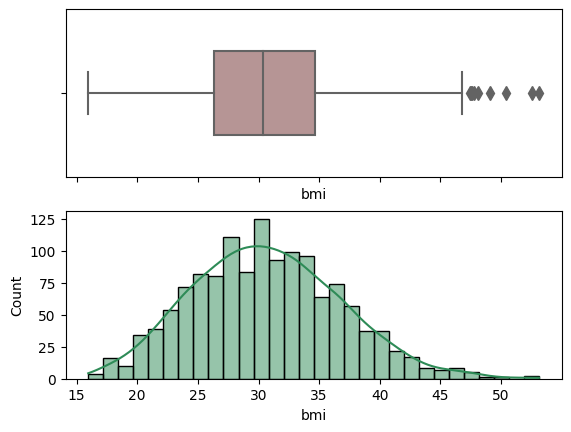

In [7]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)

sns.boxplot(x="bmi", data=df, width=0.5, fliersize=7, color="rosybrown", ax=ax_box);
sns.histplot(x="bmi", data=df, kde=True, bins=30, color="seagreen", ax=ax_hist);

If we look at the BMI distribution, the distribution looks normal, but there are outliers. We will be looking at this going forward.

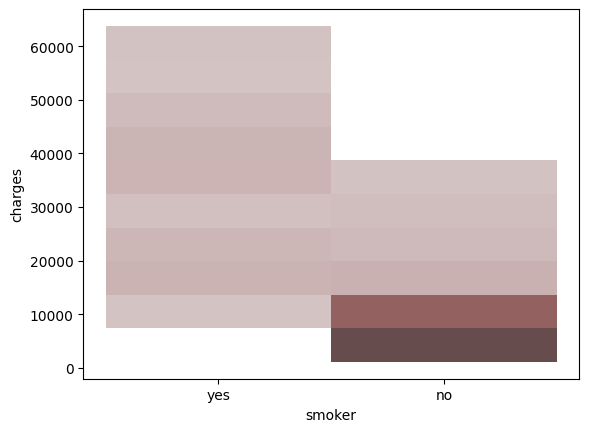

In [8]:
sns.histplot(df, x="smoker", y="charges", bins=10, color="rosybrown");

When we compare smoking and charges, we find that smokers have significantly higher charges. The lowest charges values are intensive in non-smokers.

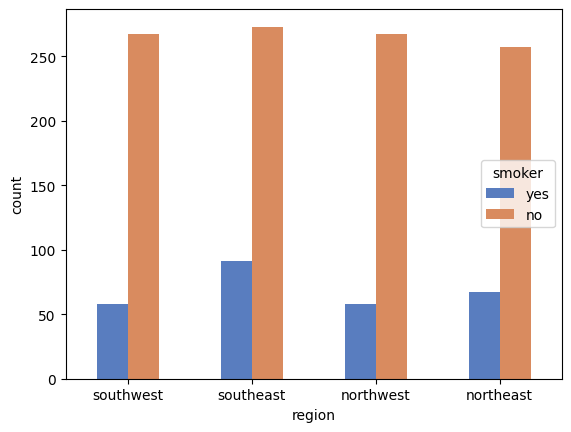

In [9]:
sns.countplot(df, x="region", hue="smoker", width=0.5, palette="muted")
plt.legend(loc="center right", title="smoker");

When we compare the region and smoking status, there is not much difference.

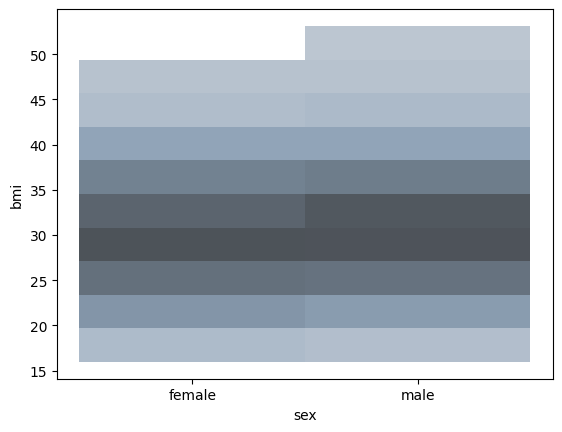

In [10]:
sns.histplot(df, x="sex", y="bmi", bins=10, color="slategray");

It can be said that BMI values are not related to sex.

To see the region with the highest number of children, let's group the regions together and look at the total number of children.

In [11]:
df_child = df.groupby("region").sum().reset_index()
df_child[["region","children"]]

,region,children
0,northeast,339
1,northwest,373
2,southeast,382
3,southwest,371


When we analyze the averages, the region with the highest number of children is 'southeast' and it is not very different from the others.

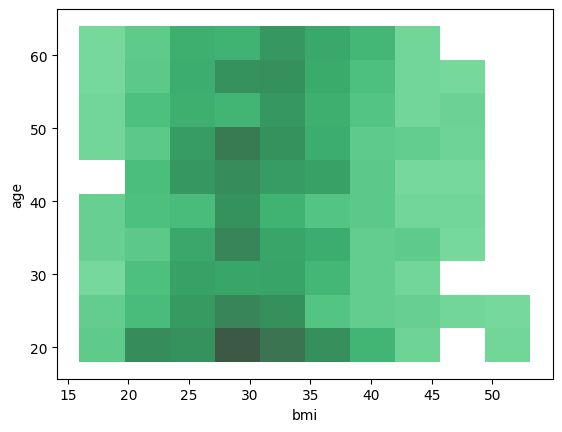

In [12]:
sns.histplot(df, x="bmi", y="age", bins=10, color="seagreen");

If we look at the graph of the BMI and the age, the BMI does not change much with the age, so there is not much relationship between them.

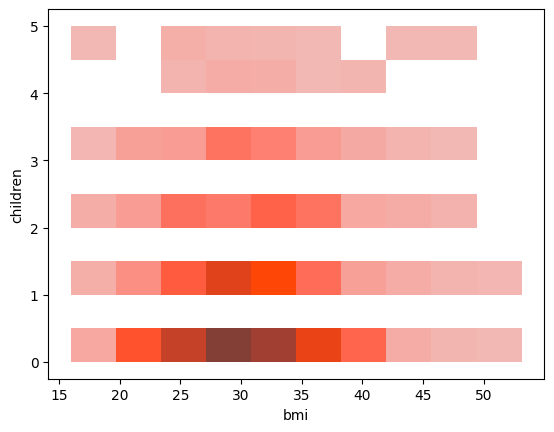

In [13]:
sns.histplot(df, x="bmi", y="children", bins=10, color="orangered");

If we look at the graph of number of children and BMI, the distribution is similar according to the number of children. Those with 5 children are closer to being obese than those with no children (BMI>30 is considered obese). Let's also see if BMI has an impact on charges.

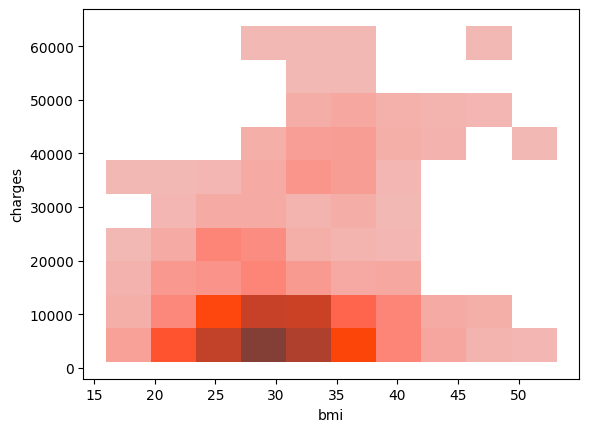

In [14]:
sns.histplot(df, x="bmi", y="charges", bins=10, color="orangered");

If we look at the graph of BMI and charges, we see again a density close to obesity. In this case, the above "close to obesity in those without children" is meaningless. This means the dataset samples are randomly at this density. However, with high BMIs, the charges are either low or high. These values seem to increase with the presence of another variable in addition to BMI. This could be smoking, as we examined above. Let's look at that as well.

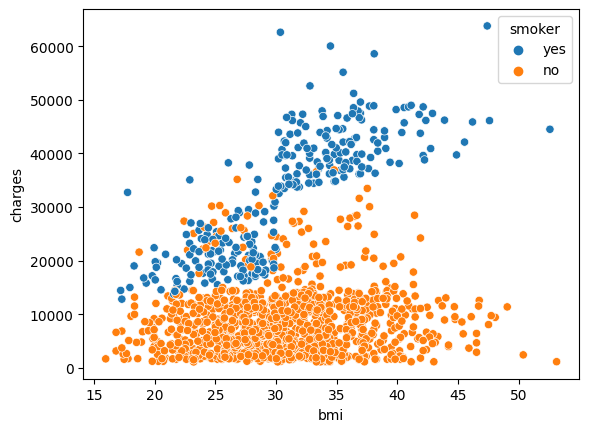

In [15]:
sns.scatterplot(df, x="bmi", y="charges", hue="smoker");

According to the graph, this variable is 'smoker'. Charges increase according to BMI, but also according to smokers.

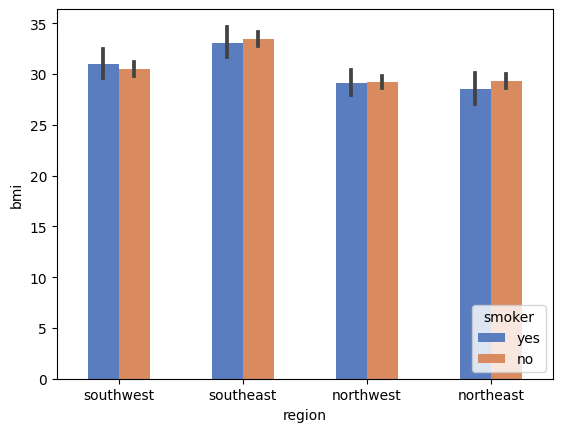

In [16]:
sns.barplot(df, x="region", y="bmi", hue="smoker", width=0.5, palette="muted")
plt.legend(loc="lower right", title="smoker");

When we compare BMI, region of residence, and smoking status, BMI doesn't change much by region or smoking status. Similarly, smoking status doesn't change much by region.

Let's examine the outliers we see in the BMI distribution. We look at the number of outliers as below. 9 is a small number, we can delete these rows. However, if we delete the rows and examine the BMI statistic values, deleting these rows does not have much effect. We will not delete the rows.

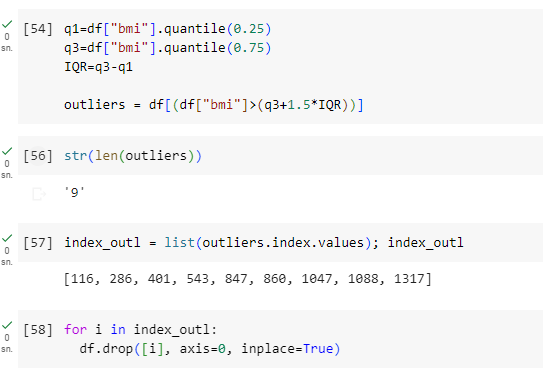

If we delete the rows and look at the BMI statistic values (images below), deleting these rows doesn't have much effect. We will not delete the rows.

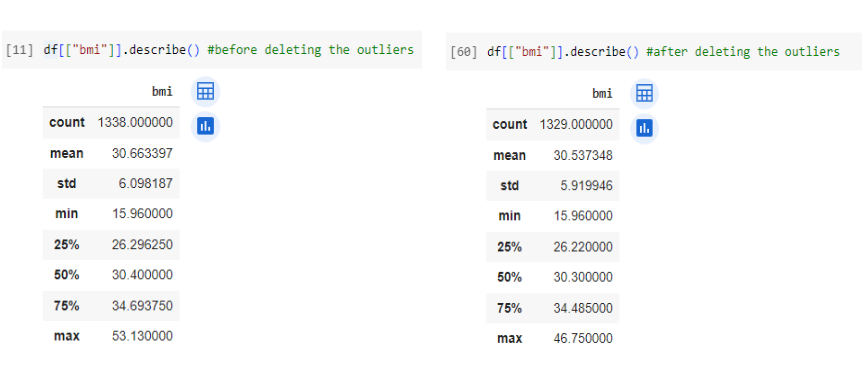

Let's start with model selection and try Linear Regression and Random Forest Regression models.

We will prepare our data. First, we will split our dataset into dependent and independent variables. The variable 'charges' is our dependent data.

In [17]:
X = df.iloc[:,:-1]; X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [18]:
y = df.iloc[:,-1]; y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

We need to convert our categorical data into binary values. We will apply Label Encoding to a column with only two categories and One Hot Encoding to a column with more than two categories.

In [19]:
col_list = ["sex", "smoker"]
le = LabelEncoder()
X[col_list] = X[col_list].apply(le.fit_transform)

In [20]:
ct = ColumnTransformer(transformers = [("encoderone", OneHotEncoder(), [-1])], remainder = "passthrough")
X = np.array(ct.fit_transform(X))

Let's split our data into test and training sets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [22]:
X_train

array([[ 0.  ,  1.  ,  0.  , ..., 26.6 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., 21.4 ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  , ..., 37.29,  0.  ,  0.  ],
       ...,
       [ 1.  ,  0.  ,  0.  , ..., 34.96,  2.  ,  1.  ],
       [ 0.  ,  0.  ,  1.  , ..., 22.22,  2.  ,  1.  ],
       [ 0.  ,  0.  ,  1.  , ..., 27.94,  1.  ,  0.  ]])

Since the data are numerically very far apart according to the variables, we use scaling to bring them closer together. Let's use the Standard Scaling method.

In [23]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
#StandartScaler yapabilmek için DataFrame'e dönüştürmeliyiz.

In [24]:
y_train

,charges
216,10355.64100
731,10065.41300
866,1141.44510
202,13012.20865
820,7445.91800
...,...
715,12146.97100
905,4564.19145
1096,44641.19740
235,19444.26580


In [25]:
ct = ColumnTransformer(transformers = [("scalerst", StandardScaler(), [4,6])], remainder = "passthrough")
X_train = np.array(ct.fit_transform(X_train))

ct = ColumnTransformer(transformers = [("scalerst", StandardScaler(), [4,6])], remainder = "passthrough")
X_test = np.array(ct.fit_transform(X_test))

ct = ColumnTransformer(transformers = [("scalerst", StandardScaler(), [0])], remainder = "passthrough")
y_train = np.array(ct.fit_transform(y_train))

ct = ColumnTransformer(transformers = [("scalerst", StandardScaler(), [0])], remainder = "passthrough")
y_test = np.array(ct.fit_transform(y_test))

In [26]:
X_train

array([[ 1.00228629, -0.66474472,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.00228629, -1.51402369,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-1.50426607,  1.08117685,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.85905473,  0.70063454,  1.        , ...,  0.        ,
         2.        ,  1.        ],
       [ 0.07128113, -1.38009893,  0.        , ...,  0.        ,
         2.        ,  1.        ],
       [ 1.28874942, -0.44589206,  0.        , ...,  1.        ,
         1.        ,  0.        ]])

We will try the Linear Regression model and analyze its score.

In [27]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [28]:
linreg_score = cross_val_score(linreg, X, y, cv=10, scoring="r2")
linreg_score_mean = linreg_score.mean();
linreg_score_mean

0.7445006998667603

The score is not very good. Let's try the Random Forest Regression model.

In [29]:
randreg = RandomForestRegressor(random_state=0)
randreg.fit(X_train, y_train.ravel())

RandomForestRegressor(random_state=0)

In [30]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="r2")
randreg_score_mean_1 = randreg_score.mean();
print("R^2:",randreg_score_mean_1)

R^2: 0.8376581559590803


The score is better with the Random Forest method. Let's look at the other scores and try to improve them by adjusting the hyperparameters. We will try to find the optimal parameters using the Grid Search method.

In [31]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="neg_mean_squared_error")
randreg_score_mean_2 = randreg_score.mean();
print("MSE:",randreg_score_mean_2)

MSE: -23529451.23416769


In [32]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="neg_root_mean_squared_error")
randreg_score_mean_3 = randreg_score.mean();
print("RMSE:",randreg_score_mean_3)

RMSE: -4839.770262975149


In [33]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="neg_mean_absolute_error")
randreg_score_mean_4 = randreg_score.mean();
print("MAE:",randreg_score_mean_4)

MAE: -2664.5874343145015


In [34]:
randreg = RandomForestRegressor(random_state=0)

hyper_params = {"n_estimators": [10,100,200], "max_depth": [4,5,6,7,8,None], "max_features": ["sqrt","log2", None]}
grid_search = GridSearchCV(estimator=randreg, param_grid=hyper_params, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train.ravel())

bestscore = grid_search.best_score_
bestparam = grid_search.best_params_

In [35]:
bestscore

0.851878219818202

In [36]:
bestparam

{'max_depth': 4, 'max_features': None, 'n_estimators': 200}

We will put these parameters into our RandomForestRegressor algorithm and analyze the score.

In [37]:
randreg = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=4, max_features=None)
randreg.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=4, max_features=None, n_estimators=200,
                      random_state=0)

In [38]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="r2")
randreg_score_mean_1 = randreg_score.mean();
print("R^2:",randreg_score_mean_1)

R^2: 0.8582831811349247


In [39]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="neg_mean_squared_error")
randreg_score_mean_2 = randreg_score.mean();
print("MSE:",randreg_score_mean_2)

MSE: -20510339.806980003


In [40]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="neg_root_mean_squared_error")
randreg_score_mean_3 = randreg_score.mean();
print("RMSE:",randreg_score_mean_3)

RMSE: -4512.658097966196


In [41]:
randreg_score = cross_val_score(randreg, X, y, cv=5, scoring="neg_mean_absolute_error")
randreg_score_mean_4 = randreg_score.mean();
print("MAE:",randreg_score_mean_4)

MAE: -2554.2246311391814


In regression scores, we want the r2 value to increase and the MSE, RMSE and MAE values to decrease. We see that the model we optimized gives better results.